In [1]:
import pandas as pd
import numpy as np
import sys, zipfile, os, time
import matplotlib
import matplotlib.pyplot as plt
import glob
import datetime
import urllib3
import cdsapi
import xarray
import shutil
import warnings
import pickle
import h5py
import netCDF4
warnings.filterwarnings('ignore')

sys.path.append(os.getcwd()+'/../cds-backend/code/')
import cds_eua3 as eua


In [2]:
def get_adj(station, tarvar):
    import datetime
    if tarvar == 'directionbias':
        cdsvar = 'wind_direction'
    elif tarvar == 'uwindbias':
        cdsvar = 'u_component_of_wind'
    elif tarvar == 'vwindbias':
        cdsvar = 'v_component_of_wind'
    else:
        print('not an available wind variable')
        return 0, 0, 0, 0, 0
    """Compare created adjustment to downloaded adjustment
    """
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    file = glob.glob('./Wind_adjustment/*/*winddir*'+station+'*')[0]
    data = eua.CDMDataset(file)#.to_dataframe()
    display(data)
    date0 = datetime.datetime.strptime('1900-01-01', "%Y-%m-%d")

    lessdates = []
    basedatum = data.datum[:]
    for i in range(basedatum[0], basedatum[-1], 1000):
        lessdates.append(date0 + datetime.timedelta(days=int(i)))
    dates = lessdates
    
    press = data.press[:]
    print(press)
    nightadj = data[tarvar][0,:]
    dayadj = data[tarvar][1,:]    
    
    c = cdsapi.Client()
    r = c.retrieve('insitu-comprehensive-upper-air-observation-network',
                   {'variable': cdsvar,
                    'optional':['wind_bias_estimate'],
                    'statid': station,
                    'pressure_level':[10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]
                   }
                  )
    r.download(target='download.zip')
    assert os.stat('download.zip').st_size == r.content_length, "Downloaded file is incomplete"
    z = zipfile.ZipFile('download.zip')
    z.extractall(path='./tocompare/wind/cds_'+station)
    z.close()
    cdsfile = glob.glob('./tocompare/wind/cds_'+ station +'/*.nc')
    cdsdata=eua.CDMDataset(cdsfile[0]).to_dataframe()
    daycdsdata = cdsdata[cdsdata.time.dt.hour > 6][cdsdata.time.dt.hour <= 18]
    nightcdsdata = cdsdata[cdsdata.time.dt.hour <= 6].append(cdsdata[cdsdata.time.dt.hour > 18])
    
    
    calc_day_out = {}
    calc_night_out = {}
    cds_day_out = {}
    cds_night_out = {}
    for i in [10,20,30,50,70,100,150,200,250,300,400,500,700,850,925,1000]:
        calc_day_out[str(i)]=[]
        calc_night_out[str(i)]=[]
        cds_day_out[str(i)]=[]
        cds_night_out[str(i)]=[]
        
    for i in range(len(dates)-1):
        for j in range(len(press)):
            try:
                d_adjd = dayadj[j][i*300]
                calc_day_out[str(int(press[j]))].append(d_adjd)
            except:
                calc_day_out[str(int(press[j]))].append(np.nan) 
            try:
                d_cdsd = daycdsdata[daycdsdata.plev == press[j]*100][daycdsdata.time >= dates[i]][daycdsdata.time < dates[i+1]]
                cds_day_out[str(int(press[j]))].append(d_cdsd['wind_bias_estimate'].iloc[0])
            except:
                cds_day_out[str(int(press[j]))].append(np.nan)
            try:
                n_cdsd = nightcdsdata[nightcdsdata.plev == press[j]*100][nightcdsdata.time >= dates[i]][nightcdsdata.time < dates[i+1]]
                cds_night_out[str(int(press[j]))].append(n_cdsd['wind_bias_estimate'].iloc[0])
            except:
                cds_night_out[str(int(press[j]))].append(np.nan)
            try:
                n_adjd = nightadj[j][i*300]
                calc_night_out[str(int(press[j]))].append(n_adjd)
            except:
                calc_night_out[str(int(press[j]))].append(np.nan)
                
    return dates, cds_day_out, cds_night_out, calc_day_out, calc_night_out

In [3]:
def plt_adj(dates, cdata, adata, plev, station, time, adj, save):
#     dates_list = [datetime.datetime.strptime(date, '%Y%m%d').date() for date in dates[1:]]
    fig, ax = plt.subplots()
    if not np.isnan(cdata[str(plev)]).all():
        ax.scatter(dates[1:], np.asarray(cdata[str(plev)]), label='CDS', alpha=0.7)
    if not np.isnan(adata[str(plev)]).all():
        ax.scatter(dates[1:], np.asarray(adata[str(plev)]), label='Calc', alpha=0.7)
    ax.set(xlabel='breaks', ylabel='Adjustment: '+adj,
           title= str(station)+' Temperature '+str(plev)+' hPa '+time)
    ax.legend()
    ax.grid()
    
    if save:
        fig.savefig(str(station)+'_Temperature_'+str(plev)+'_hPa_'+time+'.png')
    plt.show()
    return

File: <HDF5 file "feedbackmergedwinddir070219.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 20.94 MB
Filename: ./Wind_adjustment/070219/feedbackmergedwinddir070219.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 28125)
 - V | datum________________________________________ : : (28125,)
 - V | directionbias________________________________ : : (2, 16, 28125)
 - V | era5_fgdep___________________________________ : : (2, 16, 28125)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 28125)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (28125,)
 - V | uwindb

2021-05-05 11:32:30,156 INFO Welcome to the CDS
2021-05-05 11:32:30,158 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 11:32:30,602 INFO Request is completed
2021-05-05 11:32:30,605 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620205437.7967303-22840-8-25a6ee3e-6b70-460b-8c88-2c090ca3c4eb.zip to download.zip (22.7M)
2021-05-05 11:32:33,848 INFO Download rate 7M/s     
2021-05-05 11:32:34,199 INFO Reading Profile on slice(None, None, None)
2021-05-05 11:32:36,630 INFO Note: NumExpr detected 32 cores but "NUMEXPR_MAX_THREADS" not set, so enforcing safe limit of 8.
2021-05-05 11:32:36,632 INFO NumExpr defaulting to 8 threads.


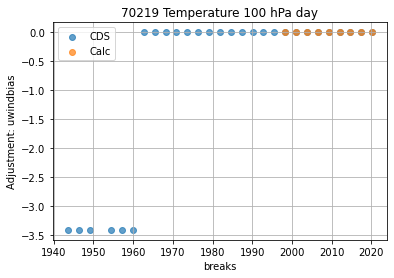

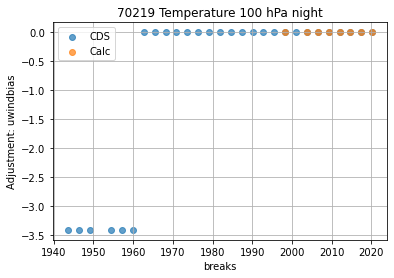

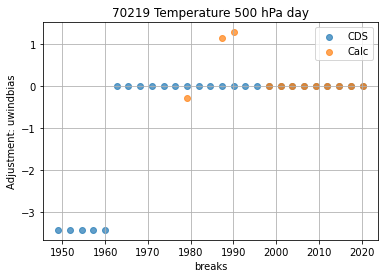

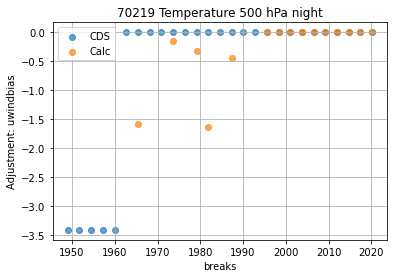

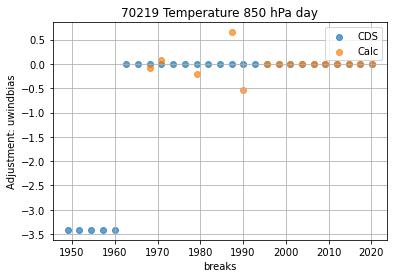

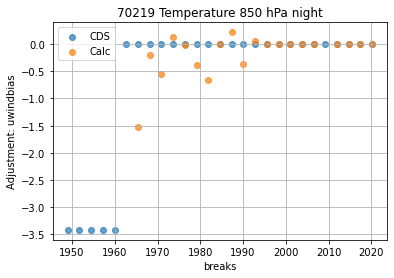

In [4]:
station = '70219'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir070219.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 20.94 MB
Filename: ./Wind_adjustment/070219/feedbackmergedwinddir070219.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 28125)
 - V | datum________________________________________ : : (28125,)
 - V | directionbias________________________________ : : (2, 16, 28125)
 - V | era5_fgdep___________________________________ : : (2, 16, 28125)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 28125)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (28125,)
 - V | uwindb

2021-05-05 11:32:49,364 INFO Welcome to the CDS
2021-05-05 11:32:49,364 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 11:32:49,539 INFO Request is queued
2021-05-05 11:32:50,576 INFO Request is running
2021-05-05 11:32:54,402 INFO Request is completed
2021-05-05 11:32:54,404 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620207173.446532-5037-6-2fa479d7-cdf2-4bf9-a2f3-bc9f0d72522a.zip to download.zip (22.7M)
2021-05-05 11:32:57,713 INFO Download rate 6.9M/s   
2021-05-05 11:32:58,073 INFO Reading Profile on slice(None, None, None)


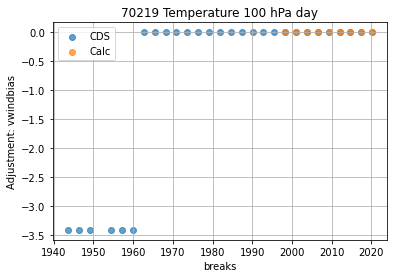

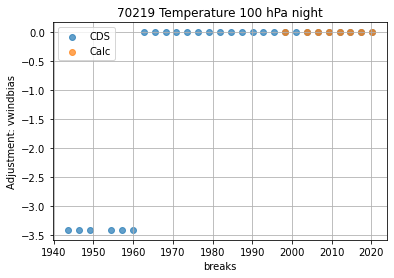

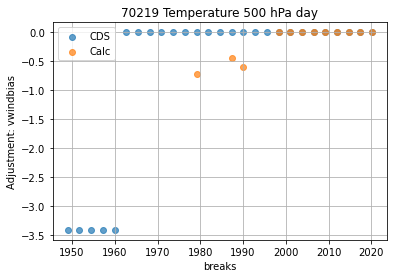

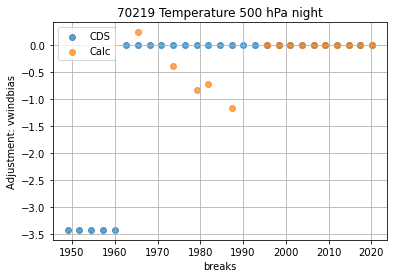

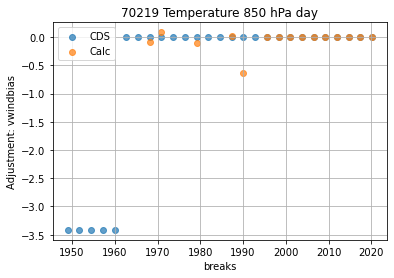

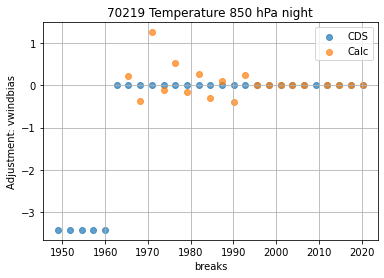

In [5]:
station = '70219'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir070219.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 20.94 MB
Filename: ./Wind_adjustment/070219/feedbackmergedwinddir070219.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 28125)
 - V | datum________________________________________ : : (28125,)
 - V | directionbias________________________________ : : (2, 16, 28125)
 - V | era5_fgdep___________________________________ : : (2, 16, 28125)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 28125)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (28125,)
 - V | uwindb

2021-05-05 11:33:16,622 INFO Welcome to the CDS
2021-05-05 11:33:16,624 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 11:33:16,811 INFO Request is completed
2021-05-05 11:33:16,813 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620130746.408693-7818-3-dffbac9b-256c-4e83-85c5-09063c1bd783.zip to download.zip (21.9M)
2021-05-05 11:33:19,902 INFO Download rate 7.1M/s   
2021-05-05 11:33:20,186 INFO Reading Profile on slice(None, None, None)


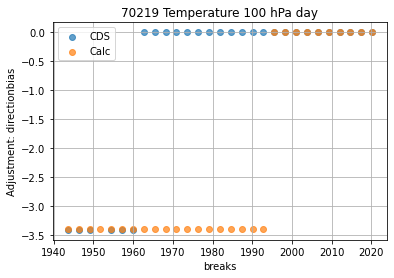

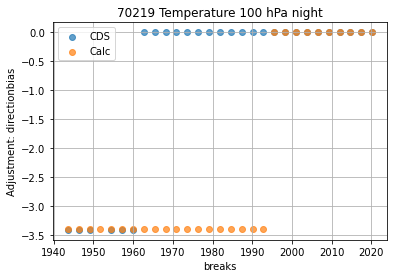

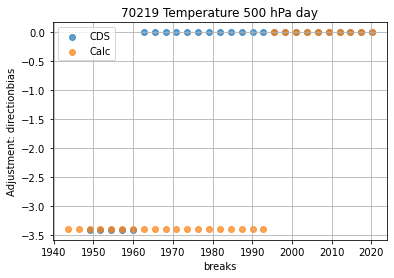

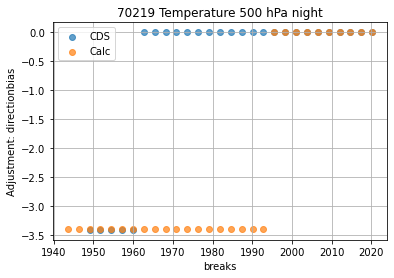

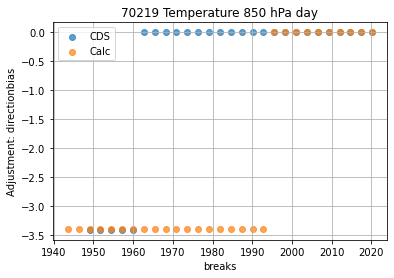

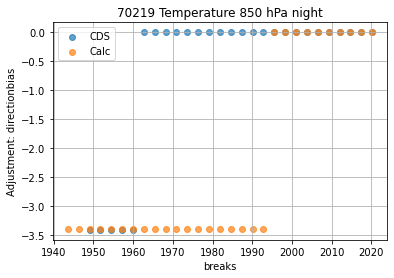

In [6]:
station = '70219'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

File: <HDF5 file "feedbackmergedwinddir010393.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 16.13 MB
Filename: ./Wind_adjustment/010393/feedbackmergedwinddir010393.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 21657)
 - V | datum________________________________________ : : (21657,)
 - V | directionbias________________________________ : : (2, 16, 21657)
 - V | era5_fgdep___________________________________ : : (2, 16, 21657)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 21657)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (21657,)
 - V | uwindb

2021-05-05 11:33:38,096 INFO Welcome to the CDS
2021-05-05 11:33:38,098 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 11:33:38,313 INFO Request is queued
2021-05-05 11:33:39,353 INFO Request is running
2021-05-05 11:33:59,339 INFO Request is completed
2021-05-05 11:33:59,343 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620207233.699866-5039-6-f91295cb-a6b9-49a4-9243-fec90d6725d8.zip to download.zip (32.3M)
2021-05-05 11:34:04,094 INFO Download rate 6.8M/s   
2021-05-05 11:34:04,489 INFO Reading Profile on slice(None, None, None)


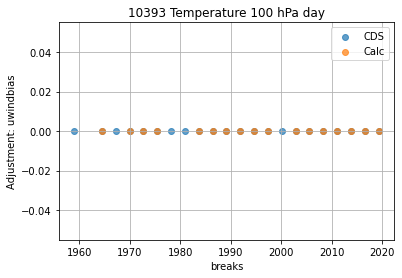

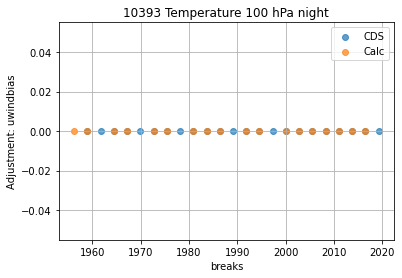

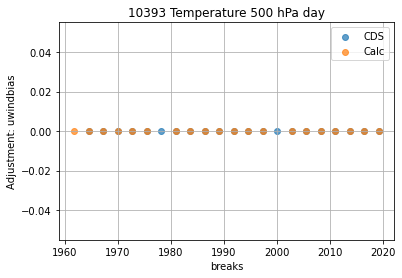

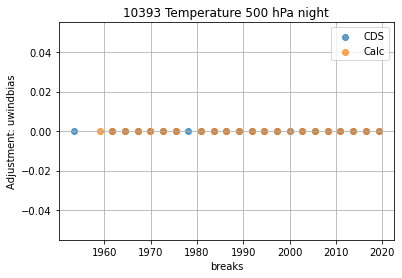

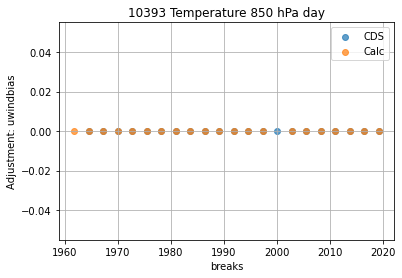

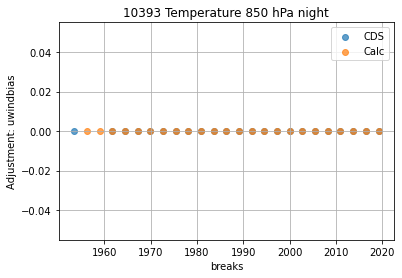

In [7]:
station = '10393'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir010393.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 16.13 MB
Filename: ./Wind_adjustment/010393/feedbackmergedwinddir010393.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 21657)
 - V | datum________________________________________ : : (21657,)
 - V | directionbias________________________________ : : (2, 16, 21657)
 - V | era5_fgdep___________________________________ : : (2, 16, 21657)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 21657)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (21657,)
 - V | uwindb

2021-05-05 11:34:26,736 INFO Welcome to the CDS
2021-05-05 11:34:26,738 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 11:34:26,981 INFO Request is queued
2021-05-05 11:34:28,020 INFO Request is running
2021-05-05 11:34:48,009 INFO Request is completed
2021-05-05 11:34:48,013 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620207282.5646477-26606-6-6a1bd567-9646-44a6-b546-9fd42f7caa20.zip to download.zip (32.3M)
2021-05-05 11:34:52,825 INFO Download rate 6.7M/s   
2021-05-05 11:34:53,275 INFO Reading Profile on slice(None, None, None)


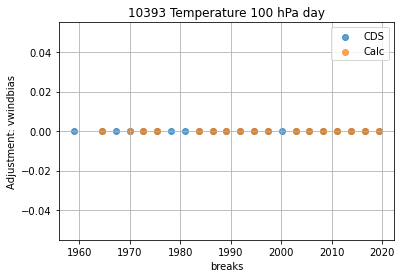

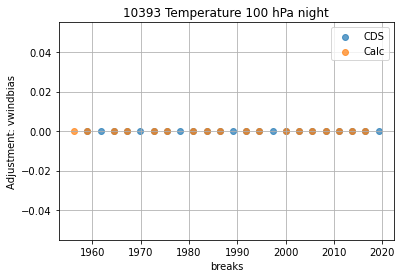

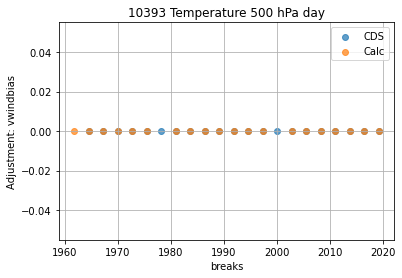

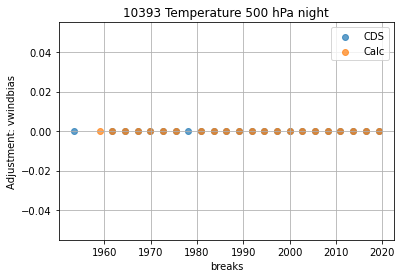

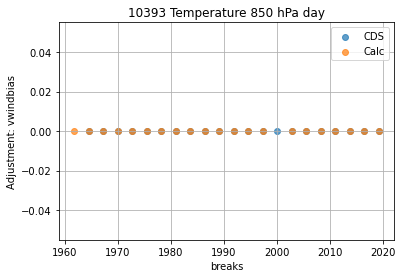

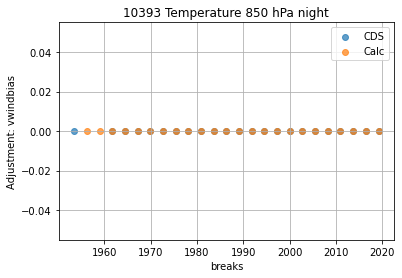

In [8]:
station = '10393'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir010393.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 16.13 MB
Filename: ./Wind_adjustment/010393/feedbackmergedwinddir010393.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 21657)
 - V | datum________________________________________ : : (21657,)
 - V | directionbias________________________________ : : (2, 16, 21657)
 - V | era5_fgdep___________________________________ : : (2, 16, 21657)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 21657)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (21657,)
 - V | uwindb

2021-05-05 11:35:15,545 INFO Welcome to the CDS
2021-05-05 11:35:15,546 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 11:35:15,742 INFO Request is completed
2021-05-05 11:35:15,743 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620203119.5553043-21294-11-b7002164-3093-4833-8ae4-e3f8ffc68cd5.zip to download.zip (31.1M)
2021-05-05 11:35:19,585 INFO Download rate 8.1M/s   
2021-05-05 11:35:20,291 INFO Reading Profile on slice(None, None, None)


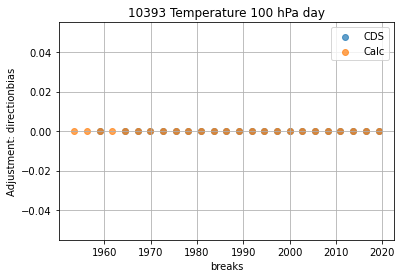

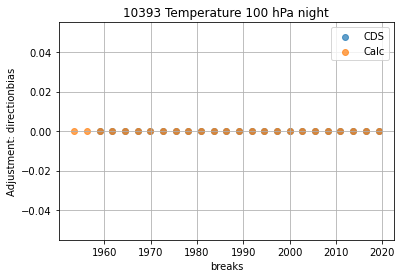

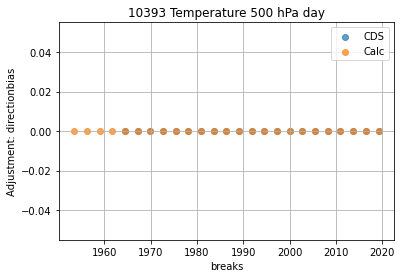

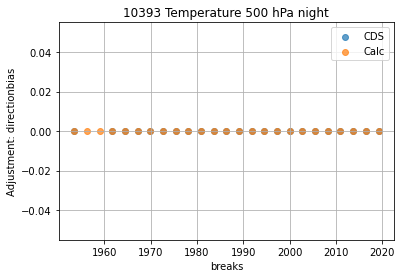

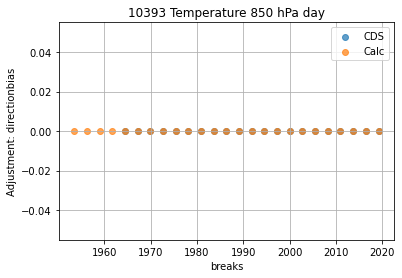

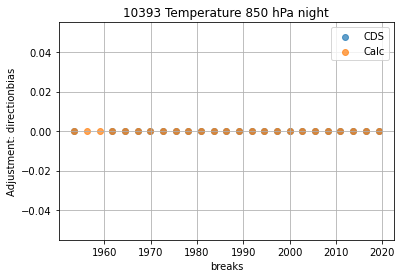

In [9]:
station = '10393'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

File: <HDF5 file "feedbackmergedwinddir011035.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 19.47 MB
Filename: ./Wind_adjustment/011035/feedbackmergedwinddir011035.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 26148)
 - V | datum________________________________________ : : (26148,)
 - V | directionbias________________________________ : : (2, 16, 26148)
 - V | era5_fgdep___________________________________ : : (2, 16, 26148)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 26148)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (26148,)
 - V | uwindb

2021-05-05 11:35:45,537 INFO Welcome to the CDS
2021-05-05 11:35:45,537 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 11:35:45,751 INFO Request is queued
2021-05-05 11:35:46,792 INFO Request is running
2021-05-05 11:35:54,038 INFO Request is completed
2021-05-05 11:35:54,041 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620207350.5158982-5041-5-0bea75e0-04e5-4f47-bce9-53a88634b150.zip to download.zip (35.8M)
2021-05-05 11:35:58,976 INFO Download rate 7.2M/s   
2021-05-05 11:35:59,402 INFO Reading Profile on slice(None, None, None)


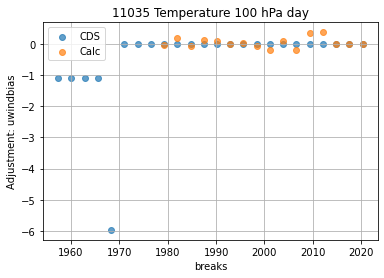

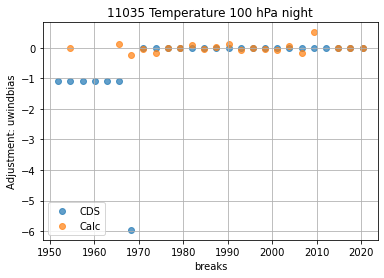

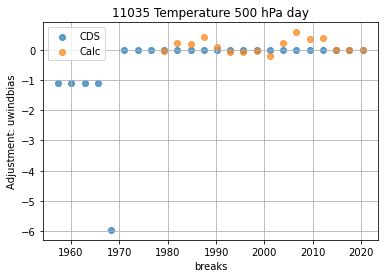

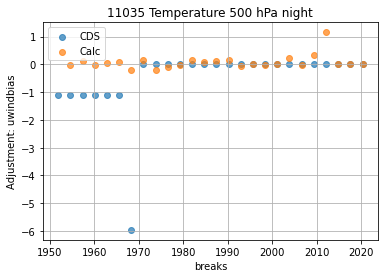

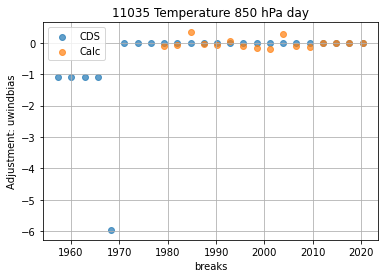

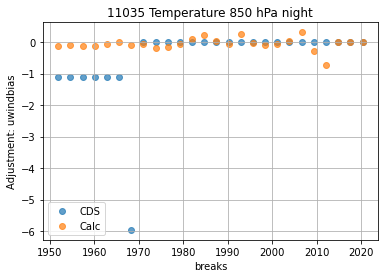

In [10]:
station = '11035'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir011035.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 19.47 MB
Filename: ./Wind_adjustment/011035/feedbackmergedwinddir011035.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 26148)
 - V | datum________________________________________ : : (26148,)
 - V | directionbias________________________________ : : (2, 16, 26148)
 - V | era5_fgdep___________________________________ : : (2, 16, 26148)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 26148)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (26148,)
 - V | uwindb

2021-05-05 11:36:27,783 INFO Welcome to the CDS
2021-05-05 11:36:27,785 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 11:36:28,082 INFO Request is queued
2021-05-05 11:36:29,121 INFO Request is running
2021-05-05 11:36:32,948 INFO Request is completed
2021-05-05 11:36:32,950 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620207392.1505783-5056-5-34658c1e-0c62-422a-a4a0-63338d8e80cc.zip to download.zip (35.8M)
2021-05-05 11:36:39,490 INFO Download rate 5.5M/s   
2021-05-05 11:36:40,022 INFO Reading Profile on slice(None, None, None)


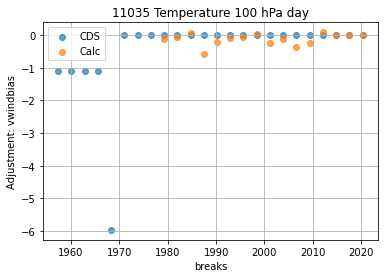

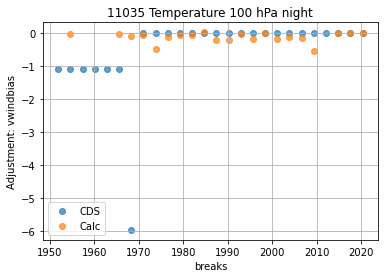

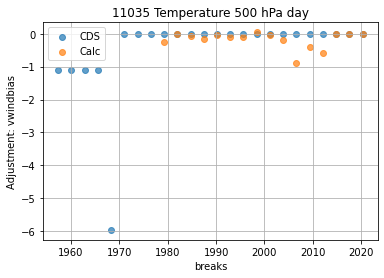

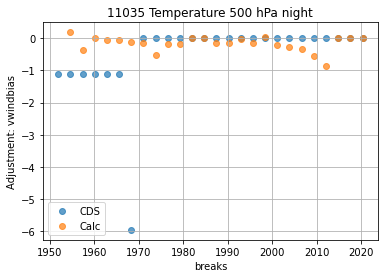

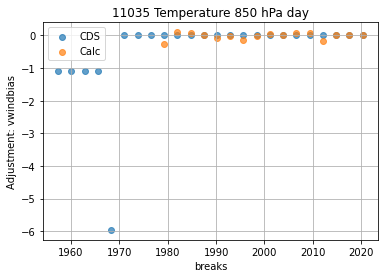

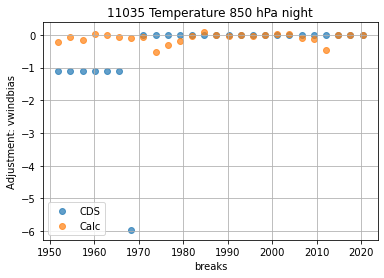

In [11]:
station = '11035'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir011035.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 19.47 MB
Filename: ./Wind_adjustment/011035/feedbackmergedwinddir011035.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 26148)
 - V | datum________________________________________ : : (26148,)
 - V | directionbias________________________________ : : (2, 16, 26148)
 - V | era5_fgdep___________________________________ : : (2, 16, 26148)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 26148)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (26148,)
 - V | uwindb

2021-05-05 11:37:05,909 INFO Welcome to the CDS
2021-05-05 11:37:05,910 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 11:37:06,215 INFO Request is completed
2021-05-05 11:37:06,217 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620206673.8221123-11993-18-81097d1f-eeb6-4e68-bc5c-88090abff6c7.zip to download.zip (34.5M)
2021-05-05 11:37:11,879 INFO Download rate 6.1M/s   
2021-05-05 11:37:12,418 INFO Reading Profile on slice(None, None, None)


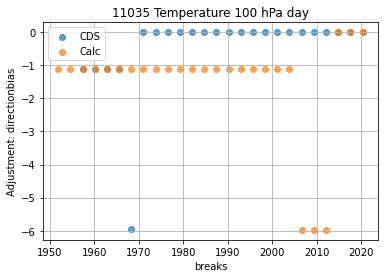

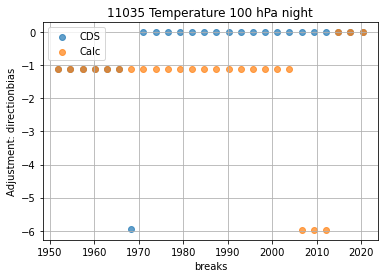

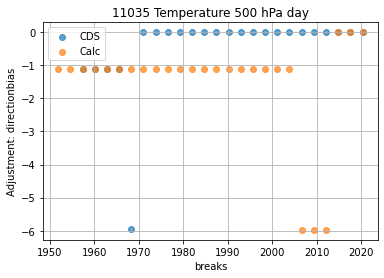

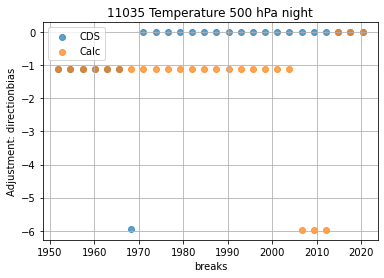

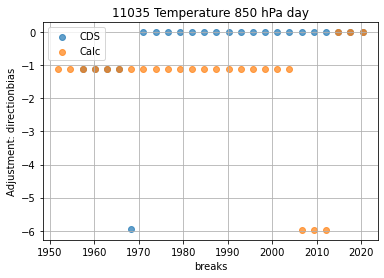

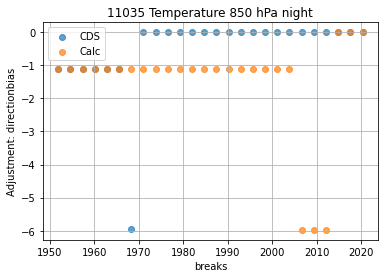

In [12]:
station = '11035'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

---

File: <HDF5 file "feedbackmergedwinddir091413.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 18.85 MB
Filename: ./Wind_adjustment/091413/feedbackmergedwinddir091413.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 25304)
 - V | datum________________________________________ : : (25304,)
 - V | directionbias________________________________ : : (2, 16, 25304)
 - V | era5_fgdep___________________________________ : : (2, 16, 25304)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 25304)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (25304,)
 - V | uwindb

2021-05-05 11:37:35,532 INFO Welcome to the CDS
2021-05-05 11:37:35,532 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 11:37:35,754 INFO Request is queued
2021-05-05 11:37:36,796 INFO Request is running
2021-05-05 11:37:38,336 INFO Request is completed
2021-05-05 11:37:38,339 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620207457.4331403-28127-5-2e878161-f7e1-495b-8a16-4849157bc041.zip to download.zip (27.5M)
2021-05-05 11:37:43,204 INFO Download rate 5.7M/s   
2021-05-05 11:37:43,547 INFO Reading Profile on slice(None, None, None)


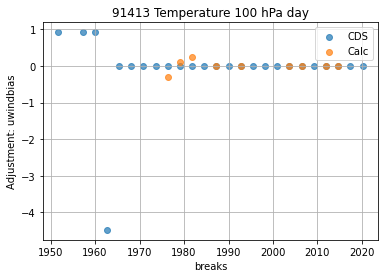

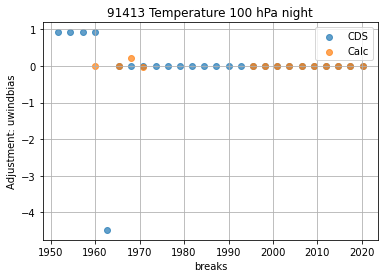

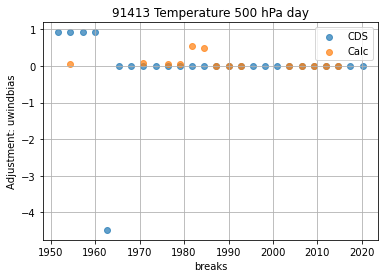

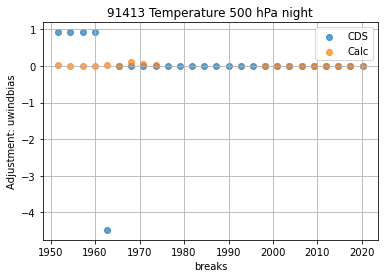

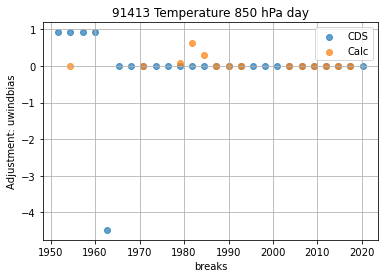

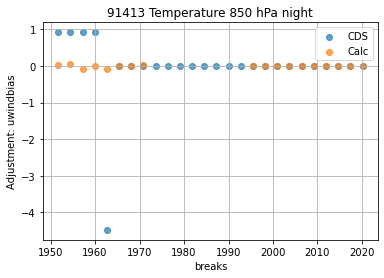

In [13]:
station = '91413'
adj = 'uwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir091413.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 18.85 MB
Filename: ./Wind_adjustment/091413/feedbackmergedwinddir091413.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 25304)
 - V | datum________________________________________ : : (25304,)
 - V | directionbias________________________________ : : (2, 16, 25304)
 - V | era5_fgdep___________________________________ : : (2, 16, 25304)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 25304)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (25304,)
 - V | uwindb

2021-05-05 11:37:59,706 INFO Welcome to the CDS
2021-05-05 11:37:59,706 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 11:37:59,903 INFO Request is queued
2021-05-05 11:38:00,942 INFO Request is running
2021-05-05 11:38:02,483 INFO Request is completed
2021-05-05 11:38:02,485 INFO Downloading http://136.156.132.176/cache-compute-0002/cache/data2/adaptor.comprehensive_upper_air.retrieve-1620207481.5831323-5523-5-291627b2-2250-43de-87cb-873f1853236f.zip to download.zip (27.6M)
2021-05-05 11:38:06,980 INFO Download rate 6.1M/s   
2021-05-05 11:38:07,352 INFO Reading Profile on slice(None, None, None)


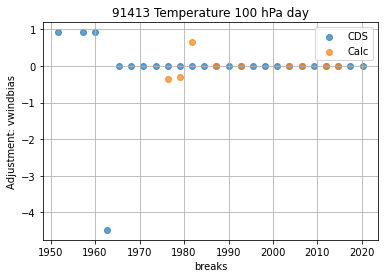

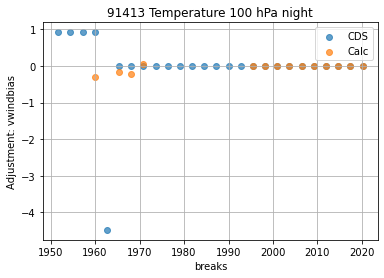

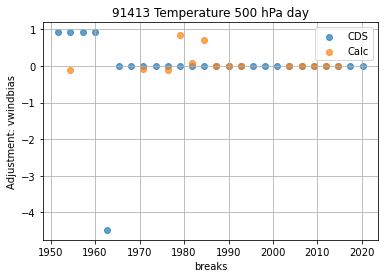

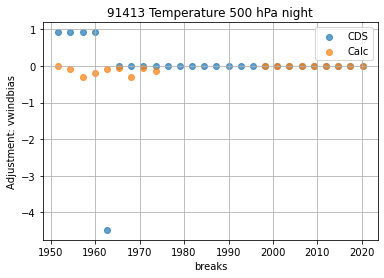

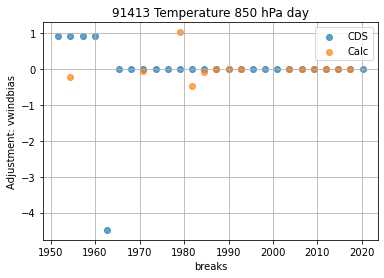

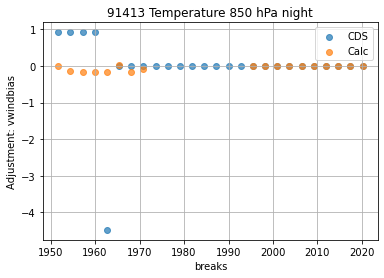

In [14]:
station = '91413'
adj = 'vwindbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)

File: <HDF5 file "feedbackmergedwinddir091413.nc" (mode r)>
Permissions: RW (mblaschek)
Filesize: 18.85 MB
Filename: ./Wind_adjustment/091413/feedbackmergedwinddir091413.nc
(G)roups/(V)ariables: 

 - V | bias_estimate________________________________ : : (2, 16, 25304)
 - V | datum________________________________________ : : (25304,)
 - V | directionbias________________________________ : : (2, 16, 25304)
 - V | era5_fgdep___________________________________ : : (2, 16, 25304)
 - V | hour_________________________________________ : : (2,)
 - V | hours________________________________________ : : (2, 25304)
 - V | lat__________________________________________ : : (1,)
 - V | lon__________________________________________ : : (1,)
 - V | press________________________________________ : : (16,)
 - V | pressure_____________________________________ : : (16,)
 - V | station______________________________________ : : (1,)
 - V | time_________________________________________ : : (25304,)
 - V | uwindb

2021-05-05 11:38:21,795 INFO Welcome to the CDS
2021-05-05 11:38:21,797 INFO Sending request to https://sis-dev.climate.copernicus.eu/api/v2/resources/insitu-comprehensive-upper-air-observation-network


[  10.   20.   30.   50.   70.  100.  150.  200.  250.  300.  400.  500.
  700.  850.  925. 1000.]


2021-05-05 11:38:22,022 INFO Request is completed
2021-05-05 11:38:22,025 INFO Downloading http://136.156.132.176/cache-compute-0000/cache/data1/adaptor.comprehensive_upper_air.retrieve-1620206842.4680758-12353-18-366f06f6-b322-4646-82cd-8f74e9fc46a2.zip to download.zip (27M)
2021-05-05 11:38:26,215 INFO Download rate 6.4M/s   
2021-05-05 11:38:26,590 INFO Reading Profile on slice(None, None, None)


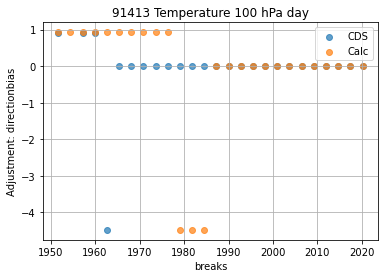

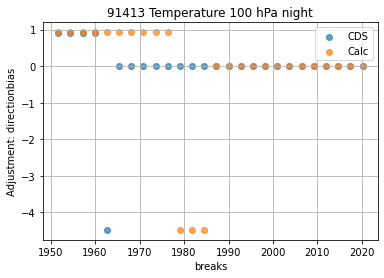

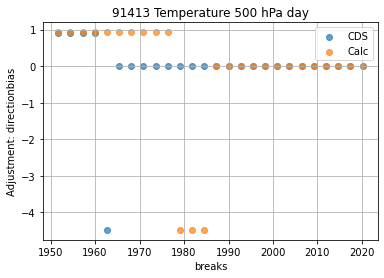

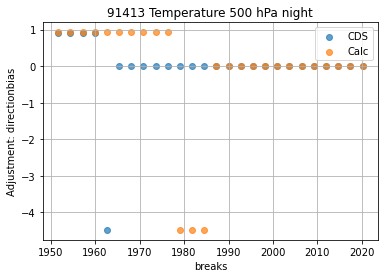

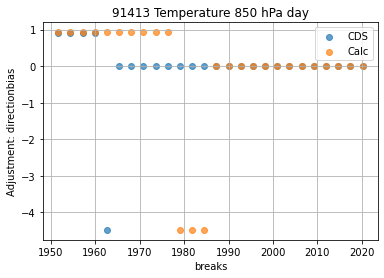

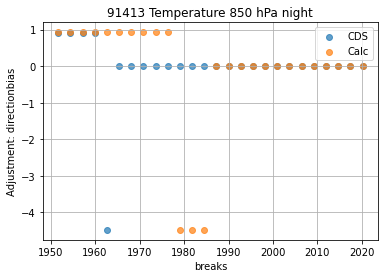

In [15]:
station = '91413'
adj = 'directionbias'
dates, dcd, ncd, dd, nd = get_adj(station, adj)

plt_adj(dates, dcd, dd, 100, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 100, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 500, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 500, station, 'night', adj, save=False)
plt_adj(dates, dcd, dd, 850, station, 'day', adj, save=False)
plt_adj(dates, ncd, nd, 850, station, 'night', adj, save=False)